In [1]:
!pip install tf-explain

     |████████████████████████████████| 43 kB 100 kB/s            


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,Input,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
def explain_model(img,model,index):
    image_array= image.img_to_array(img)
    data = ([image_array],None)
    explainer = GradCAM()
    grid = explainer.explain(data,model,class_index=index)
    explainer.save(grid, '.', 'test' + 'grad_cam.png')
    fig,ax = plt.subplots(1,2)
    decoded_img = image.load_img('./testgrad_cam.png',target_size=(224,224))
    ax[0].imshow(img)
    ax[1].imshow(decoded_img,cmap='RdGy')    

In [4]:
def classify_sampleimage(img_path,index):
    img = image.load_img(img_path,target_size=(224,224))
    image_array= image.img_to_array(img)
    img_batch = np.expand_dims(image_array,axis=0)
#     model = ResNet50()
    model = ResNet50(weights='imagenet',include_top=True)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    explain_model(img,model,index)
    print(decode_predictions(prediction,top=3)[0])

2022-01-19 07:21:47.567079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 07:21:47.699136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 07:21:47.699908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 07:21:47.701056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102981632/102967424 [==============================] - 1s 0us/step


2022-01-19 07:21:52.671244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 07:21:54.201124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49152/35363 [=========================================] - 0s 0us/step
[('n02096437', 'Dandie_Dinmont', 0.6296953), ('n02098413', 'Lhasa', 0.16470082), ('n02093754', 'Border_terrier', 0.050862443)]


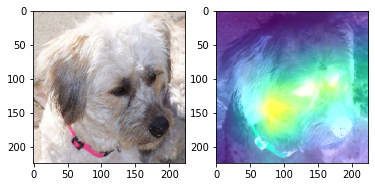

In [5]:
classify_sampleimage('../input/cat-and-dog/training_set/training_set/dogs/dog.1014.jpg',263)

[('n02124075', 'Egyptian_cat', 0.25894815), ('n02123045', 'tabby', 0.2387948), ('n02123597', 'Siamese_cat', 0.0900511)]


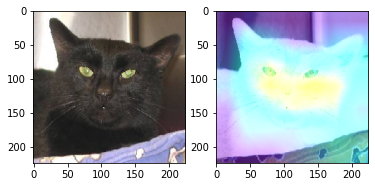

In [6]:
classify_sampleimage('../input/cat-and-dog/training_set/training_set/cats/cat.1016.jpg',281)

In [14]:
path = '../input/cat-and-dog'
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               validation_split=0.2,
                               fill_mode='nearest')

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
image_gen.flow_from_directory(path+'/'+'training_set/training_set')


Found 8005 images belonging to 2 classes.


In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [16]:
train_image_gen = image_gen.flow_from_directory(path+'/'+'training_set/training_set/',
                                               target_size = (224,224),
                                               color_mode = 'rgb',
                                               batch_size = 64,
                                               shuffle=True,
                                               subset = 'training',
                                               class_mode = 'binary')
valid_image_gen = image_gen.flow_from_directory(path+'/'+'training_set/training_set/',
                                               target_size = (224,224),
                                               color_mode = 'rgb',
                                               batch_size = 64,
                                               shuffle=True,
                                               subset = 'validation',
                                               class_mode = 'binary')
test_image_gen = valid_gen.flow_from_directory(path+'/'+'test_set/test_set/',
                                               target_size = (224,224),
                                               color_mode = 'rgb',
                                               batch_size = 64,
                                               shuffle=False,
                                               class_mode = 'binary')

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


(64, 224, 224, 3)


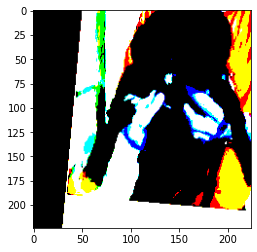

(64, 224, 224, 3)


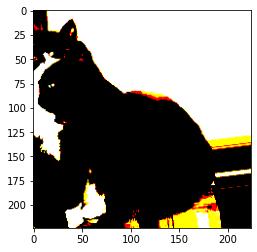

(64, 224, 224, 3)


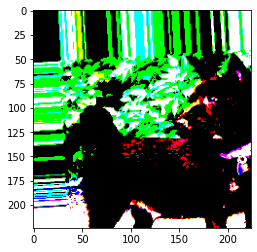

(64, 224, 224, 3)


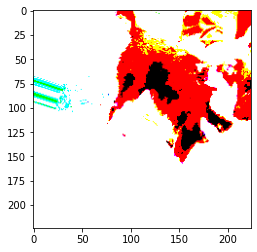

(64, 224, 224, 3)


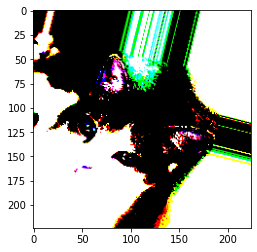

In [17]:
for _ in range(5):
    img, label = train_image_gen.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [18]:
def c_model():
    base_model = ResNet50(include_top=False,input_shape=(224,224,3))
    for layer in base_model.layers[:]:
        layer.trainable=False
    input = Input(shape=(224,224,3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(1000, activation='relu')(custom_model)
    custom_model = Dropout(0.2)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    return Model(inputs=input,outputs=predictions)

In [19]:
model = c_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 25,637,713
Trainable params: 2,050,001
Non-trainable params: 23,587,712
_______________________________________

In [20]:

model.compile(loss='binary_crossentropy',optimizer= tf.keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_image_gen,epochs=2,validation_data = valid_image_gen,callbacks=[early_stop])

Epoch 1/2
101/101 [==============================] - 145s 1s/step - loss: 0.1279 - accuracy: 0.9621 - val_loss: 0.0505 - val_accuracy: 0.9838
Epoch 2/2
101/101 [==============================] - 128s 1s/step - loss: 0.0489 - accuracy: 0.9813 - val_loss: 0.0630 - val_accuracy: 0.9794


In [48]:
img = image.load_img('../input/cat-and-dog/test_set/test_set/dogs/dog.4010.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
prediction = model.predict(preprocessed_img)
print(np.where(prediction > 0.5, 1, 0))
print(prediction)

[[1]]
[[0.99989116]]


In [49]:
img = image.load_img('../input/cat-and-dog/test_set/test_set/cats/cat.4009.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
prediction = model.predict(preprocessed_img)
print(np.where(prediction > 0.5, 1, 0))
print(prediction)

[[0]]
[[1.1041595e-06]]


In [50]:
ground_truth = test_image_gen.classes
predictions = model.predict_generator(test_image_gen)

In [53]:
pred_values = np.where(predictions > 0.5, 1, 0)
pred_values

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [54]:
from sklearn.metrics import classification_report

In [55]:
print(classification_report(ground_truth,pred_values))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1011
           1       0.99      0.98      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023

